In [9]:
"""
AMPERE: A Generic Energy Estimation Approach for On-Device Training
Implementation for Google Colab

Paper: https://intellisys.haow.us/assets/pdf/AMPERE.pdf
"""

'\nAMPERE: A Generic Energy Estimation Approach for On-Device Training\nImplementation for Google Colab\n\nPaper: https://intellisys.haow.us/assets/pdf/AMPERE.pdf\n'

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import cho_factor, cho_solve
import torch
import torch.nn as nn
import time
from typing import List, Tuple, Dict

In [11]:
# Gaussian Process Implementation
class GaussianProcess:
    """
    Gaussian Process with Matern kernel for energy prediction.
    Based on Equation 3 in the paper.
    """
    def __init__(self, length_scale=10.0, nu=2.5, noise=0.01):
        self.length_scale = length_scale
        self.nu = nu
        self.noise = noise
        self.X_train = None
        self.y_train = None
        self.K_inv = None

    def matern_kernel(self, X1, X2):
        """
        Matern kernel (nu=2.5) as specified in Equation 3.
        k(x_i, x_j) = (1 + sqrt(5)*d/l + 5*d^2/(3*l^2)) * exp(-sqrt(5)*d/l)
        """
        dists = cdist(X1.reshape(-1, 1), X2.reshape(-1, 1), metric='euclidean')
        dists = np.sqrt(5) * dists / self.length_scale

        K = (1 + dists + dists**2 / 3.0) * np.exp(-dists)
        return K

    def fit(self, X, y):
        """Fit the GP model to training data."""
        self.X_train = np.array(X)
        self.y_train = np.array(y)

        # Compute kernel matrix with noise
        K = self.matern_kernel(self.X_train, self.X_train)
        K += self.noise * np.eye(len(X))

        # Cholesky decomposition for numerical stability
        try:
            self.K_inv = np.linalg.inv(K)
        except:
            # Add more noise if singular
            K += 0.1 * np.eye(len(X))
            self.K_inv = np.linalg.inv(K)

    def predict(self, X):
        """
        Predict mean and variance for new points.
        Returns: (mean, variance)
        """
        if self.X_train is None:
            return np.zeros(len(X)), np.ones(len(X))

        X = np.array(X)
        K_s = self.matern_kernel(self.X_train, X)
        K_ss = self.matern_kernel(X, X)

        # Mean prediction
        mean = K_s.T @ self.K_inv @ self.y_train

        # Variance prediction
        v = self.K_inv @ K_s
        variance = np.diag(K_ss) - np.sum(K_s * v, axis=0) # Fixed the broadcasting issue here
        variance = np.maximum(variance, 0)  # Ensure non-negative

        return mean, variance

    def find_max_variance_point(self, X_candidates):
        """Find point with maximum variance for guided profiling."""
        _, variances = self.predict(X_candidates)
        return X_candidates[np.argmax(variances)]

In [ ]:
# Energy Measurement Simulation
class EnergyMeasurement:
    """
    Simulates energy measurement for different layer types.
    In real deployment, this would interface with actual power meters.
    """
    @staticmethod
    def measure_layer_energy(layer_type, cin=None, cout=None, input_size=28, batch_size=32):
        """
        Simulate energy measurement for a layer configuration.
        Returns energy in Joules.
        """
        # Base energy consumption patterns (simulated)
        if layer_type == 'input':
            # Input layer energy depends mainly on output channels
            base = 2.0
            scale = 0.15 * cout + 0.02 * (cout ** 2) / 50

        elif layer_type == 'output':
            # Output layer energy depends mainly on input channels
            base = 1.5
            scale = 0.12 * cin + 0.015 * (cin ** 2) / 50

        elif layer_type == 'hidden':
            # Hidden layer depends on both input and output channels
            base = 1.0
            complexity = (cin * cout) / 100
            scale = 0.08 * cin + 0.08 * cout + 0.005 * complexity
        else:
            raise ValueError(f"Unknown layer type: {layer_type}")

        # Input size factor (quadratic relationship for conv layers)
        size_factor = (input_size / 28) ** 2

        # Energy calculation with realistic noise (~5%)
        energy = (base + scale) * size_factor * (batch_size / 32)
        noise = energy * 0.05 * (np.random.random() - 0.5)

        return max(0.1, energy + noise)




In [13]:
# AMPERE Framework
class AMPERE:
    """
    Main AMPERE framework implementing the paper's approach.
    """
    def __init__(self, max_profiling_steps=8, channel_range=(8, 128)):
        self.max_profiling_steps = max_profiling_steps
        self.channel_range = channel_range

        # GP models for each layer type (Section 3.3)
        self.gp_input = GaussianProcess()
        self.gp_hidden = GaussianProcess()
        self.gp_output = GaussianProcess()

        # Profiling data storage
        self.profiling_data = {
            'input': {'X': [], 'y': []},
            'hidden': {'X': [], 'y': []},
            'output': {'X': [], 'y': []}
        }

    def profile_and_fit(self, input_size=28, batch_size=32, verbose=True):
        """
        Execute the profiling and fitting process (Section 3.2 & 3.3).

        Process:
        1. Profile output layer (direct measurement)
        2. Profile input layer (using subtractivity: Equation 1)
        3. Profile hidden layer (using subtractivity: Equation 2)
        """
        if verbose:
            print("=" * 60)
            print("AMPERE: Starting Profiling and Fitting Process")
            print("=" * 60)

        # Step 1: Profile output layer
        if verbose:
            print("\n[Step 1] Profiling Output Layer...")
        self._profile_layer('output', input_size, batch_size, verbose)

        # Step 2: Profile input layer
        if verbose:
            print("\n[Step 2] Profiling Input Layer...")
        self._profile_layer('input', input_size, batch_size, verbose)

        # Step 3: Profile hidden layers
        if verbose:
            print("\n[Step 3] Profiling Hidden Layers...")
        self._profile_layer('hidden', input_size, batch_size, verbose)

        if verbose:
            print("\n" + "=" * 60)
            print("Profiling Complete!")
            print("=" * 60)

    def _profile_layer(self, layer_type, input_size, batch_size, verbose):
        """
        Profile a specific layer type using guided profiling.
        Implements active learning with GP uncertainty (Section 3.2).
        """
        X_data = []
        y_data = []

        # Candidates for next profiling point
        candidates = np.linspace(self.channel_range[0],
                                self.channel_range[1],
                                50)

        # Initial points: sample at boundaries
        initial_points = [self.channel_range[0], self.channel_range[1]]

        for step in range(self.max_profiling_steps):
            # Select next profiling point
            if step < len(initial_points):
                next_point = initial_points[step]
            else:
                # Use GP to find point with maximum variance
                gp = self._get_gp(layer_type)
                next_point = gp.find_max_variance_point(candidates)

            # Measure energy at this point
            energy = self._measure_with_subtractivity(
                layer_type, next_point, input_size, batch_size
            )

            X_data.append(next_point)
            y_data.append(energy)

            # Update GP model
            gp = self._get_gp(layer_type)
            gp.fit(X_data, y_data)

            if verbose:
                mean, var = gp.predict([next_point])
                print(f"  Step {step+1}/{self.max_profiling_steps}: "
                      f"Channel={int(next_point)}, Energy={energy:.2f}J, "
                      f"Variance={var[0]:.4f}")

            # Early stopping if variance is low enough
            _, variances = gp.predict(candidates)
            if np.max(variances) < 0.05 * np.mean(y_data):
                if verbose:
                    print(f"  Early stopping: variance threshold reached")
                break

        # Store profiling data
        self.profiling_data[layer_type]['X'] = X_data
        self.profiling_data[layer_type]['y'] = y_data

    def _measure_with_subtractivity(self, layer_type, channels, input_size, batch_size):
        """
        Implement energy subtractivity (Equations 1 & 2 in paper).
        """
        if layer_type == 'output':
            # Direct measurement
            return EnergyMeasurement.measure_layer_energy(
                'output', cin=channels, cout=10,
                input_size=input_size, batch_size=batch_size
            )

        elif layer_type == 'input':
            # Equation 1: E_input = E_input+output - E_output
            total_energy = EnergyMeasurement.measure_layer_energy(
                'input', cin=3, cout=channels,
                input_size=input_size, batch_size=batch_size
            )
            # Estimate output energy using trained GP
            output_energy, _ = self.gp_output.predict([channels])
            return total_energy - output_energy[0]

        elif layer_type == 'hidden':
            # Equation 2: E_hidden = E_model - E_input - E_output
            # Simplified: measure for typical configuration
            return EnergyMeasurement.measure_layer_energy(
                'hidden', cin=channels, cout=channels,
                input_size=input_size, batch_size=batch_size
            )

    def _get_gp(self, layer_type):
        """Get the appropriate GP model for layer type."""
        if layer_type == 'input':
            return self.gp_input
        elif layer_type == 'hidden':
            return self.gp_hidden
        elif layer_type == 'output':
            return self.gp_output

    def estimate_energy(self, model_config):
        """
        Estimate total energy for a DNN model (Equation 4).

        Args:
            model_config: Dict with keys:
                - 'input_channels': int
                - 'hidden_layers': List[Tuple[cin, cout]]
                - 'output_channels': int

        Returns:
            Dict with energy breakdown
        """
        # Input layer energy
        input_energy, _ = self.gp_input.predict([model_config['input_channels']])
        input_energy = input_energy[0]

        # Hidden layers energy
        hidden_energies = []
        for cin, cout in model_config['hidden_layers']:
            # Simplified: scale by channel sizes
            base_energy, _ = self.gp_hidden.predict([64])  # Reference point
            scale = (cin + cout) / 128
            hidden_energies.append(base_energy[0] * scale)

        # Output layer energy
        last_cout = model_config['hidden_layers'][-1][1] if model_config['hidden_layers'] else model_config['input_channels']
        output_energy, _ = self.gp_output.predict([last_cout])
        output_energy = output_energy[0]

        # Total energy (Equation 4)
        total_energy = input_energy + sum(hidden_energies) + output_energy

        return {
            'total_energy': total_energy,
            'input_energy': input_energy,
            'hidden_energies': hidden_energies,
            'output_energy': output_energy,
            'breakdown': {
                'Input Layer': input_energy,
                **{f'Hidden Layer {i+1}': e for i, e in enumerate(hidden_energies)},
                'Output Layer': output_energy
            }
        }

    def visualize_gp_fit(self, layer_type='output'):
        """Visualize GP model fit and predictions."""
        gp = self._get_gp(layer_type)
        data = self.profiling_data[layer_type]

        if len(data['X']) == 0:
            print(f"No profiling data for {layer_type} layer")
            return

        # Generate predictions
        X_plot = np.linspace(self.channel_range[0], self.channel_range[1], 100)
        mean, variance = gp.predict(X_plot)
        std = np.sqrt(variance)

        # Plot
        plt.figure(figsize=(12, 5))

        # Left: GP fit with confidence
        plt.subplot(1, 2, 1)
        plt.plot(X_plot, mean, 'b-', label='GP Mean', linewidth=2)
        plt.fill_between(X_plot, mean - 2*std, mean + 2*std,
                        alpha=0.3, label='95% Confidence')
        plt.scatter(data['X'], data['y'], c='red', s=100,
                   zorder=5, label='Profiled Points')
        plt.xlabel('Channels', fontsize=12)
        plt.ylabel('Energy (J)', fontsize=12)
        plt.title(f'{layer_type.capitalize()} Layer: GP Prediction', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        # Right: Residuals
        plt.subplot(1, 2, 2)
        if len(data['X']) > 0:
            pred, _ = gp.predict(data['X'])
            residuals = np.array(data['y']) - pred
            plt.scatter(data['X'], residuals, c='purple', s=100)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Channels', fontsize=12)
            plt.ylabel('Residual (J)', fontsize=12)
            plt.title('Prediction Residuals', fontsize=14)
            plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()



In [ ]:
# Example Usage
def main():
    """
    Demonstrate AMPERE framework usage.
    """
    print("AMPERE: Energy Estimation for On-Device DNN Training")
    # Initialize AMPERE
    ampere = AMPERE(max_profiling_steps=8, channel_range=(8, 128))

    # Step 1: Profiling and Fitting
    print("Phase 1: Profiling and Fitting GP Models")
    ampere.profile_and_fit(input_size=28, batch_size=32, verbose=True)

    # Step 2: Visualize GP fits
    print("\n\nPhase 2: Visualizing GP Model Fits")
    for layer_type in ['output', 'input', 'hidden']:
        ampere.visualize_gp_fit(layer_type)

    # Step 3: Estimate energy for different model configurations
    print("\n\nPhase 3: Energy Estimation for Different Models")
    test_models = [
        {
            'name': 'Small CNN',
            'input_channels': 32,
            'hidden_layers': [(32, 64), (64, 64)],
            'output_channels': 10
        },
        {
            'name': 'Medium CNN',
            'input_channels': 64,
            'hidden_layers': [(64, 128), (128, 128), (128, 64)],
            'output_channels': 10
        },
        {
            'name': 'Large CNN',
            'input_channels': 128,
            'hidden_layers': [(128, 256), (256, 256), (256, 128), (128, 64)],
            'output_channels': 10
        }
    ]

    results = []
    for model in test_models:
        result = ampere.estimate_energy(model)
        results.append(result)

        print(f"\n{model['name']}:")
        print(f"  Input: {model['input_channels']} channels")
        print(f"  Hidden: {len(model['hidden_layers'])} layers")
        print(f"  Total Energy: {result['total_energy']:.2f} J")
        print(f"  Breakdown:")
        for layer_name, energy in result['breakdown'].items():
            print(f"    {layer_name}: {energy:.2f} J")

    # Step 4: Comparison visualization
    print("\n\nPhase 4: Energy Comparison Across Models")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart of total energy
    model_names = [m['name'] for m in test_models]
    total_energies = [r['total_energy'] for r in results]

    ax1.bar(model_names, total_energies, color=['#3b82f6', '#8b5cf6', '#ec4899'])
    ax1.set_ylabel('Total Energy (J)', fontsize=12)
    ax1.set_title('Total Energy Consumption', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)

    # Stacked bar chart of breakdown
    input_e = [r['input_energy'] for r in results]
    hidden_e = [sum(r['hidden_energies']) for r in results]
    output_e = [r['output_energy'] for r in results]

    x = np.arange(len(model_names))
    ax2.bar(x, input_e, label='Input Layer', color='#10b981')
    ax2.bar(x, hidden_e, bottom=input_e, label='Hidden Layers', color='#8b5cf6')
    ax2.bar(x, output_e, bottom=np.array(input_e)+np.array(hidden_e),
            label='Output Layer', color='#f59e0b')

    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.set_ylabel('Energy (J)', fontsize=12)
    ax2.set_title('Energy Breakdown by Layer Type', fontsize=14)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("completed!")

AMPERE: Energy Estimation for On-Device DNN Training
Phase 1: Profiling and Fitting GP Models
AMPERE: Starting Profiling and Fitting Process

[Step 1] Profiling Output Layer...
  Step 1/8: Channel=8, Energy=2.46J, Variance=0.0099
  Step 2/8: Channel=128, Energy=22.27J, Variance=0.0099
  Step 3/8: Channel=66, Energy=10.98J, Variance=0.0099
  Step 4/8: Channel=98, Energy=16.33J, Variance=0.0099
  Step 5/8: Channel=37, Energy=6.30J, Variance=0.0099
  Step 6/8: Channel=83, Energy=13.45J, Variance=0.0099
  Step 7/8: Channel=22, Energy=4.28J, Variance=0.0099
  Step 8/8: Channel=113, Energy=19.30J, Variance=0.0099

[Step 2] Profiling Input Layer...
  Step 1/8: Channel=8, Energy=0.79J, Variance=0.0099
  Step 2/8: Channel=128, Energy=5.96J, Variance=0.0099
  Step 3/8: Channel=66, Energy=2.58J, Variance=0.0099
  Step 4/8: Channel=98, Energy=4.94J, Variance=0.0099
  Step 5/8: Channel=37, Energy=2.06J, Variance=0.0099
  Step 6/8: Channel=83, Energy=3.79J, Variance=0.0099
  Step 7/8: Channel=22, En

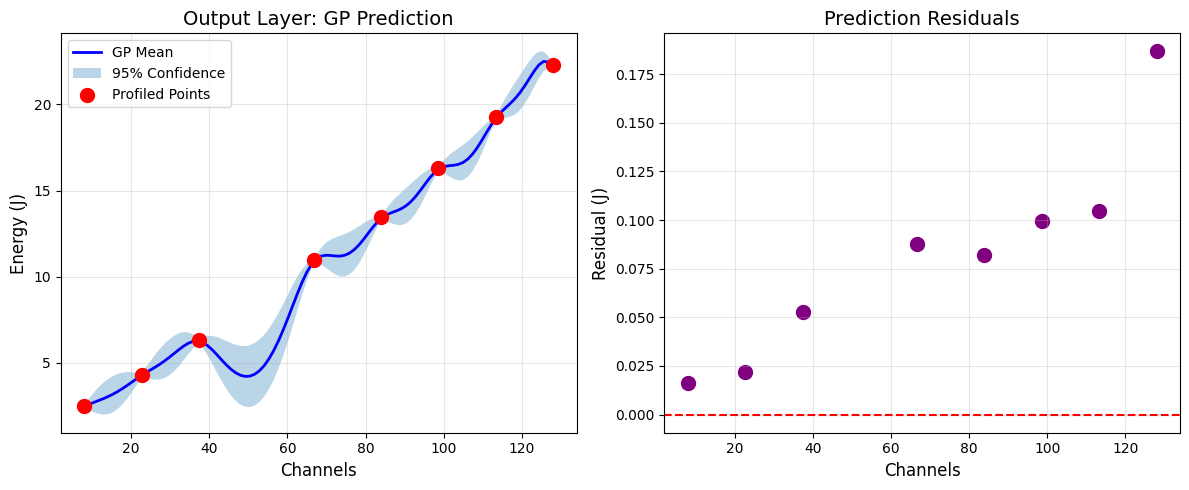

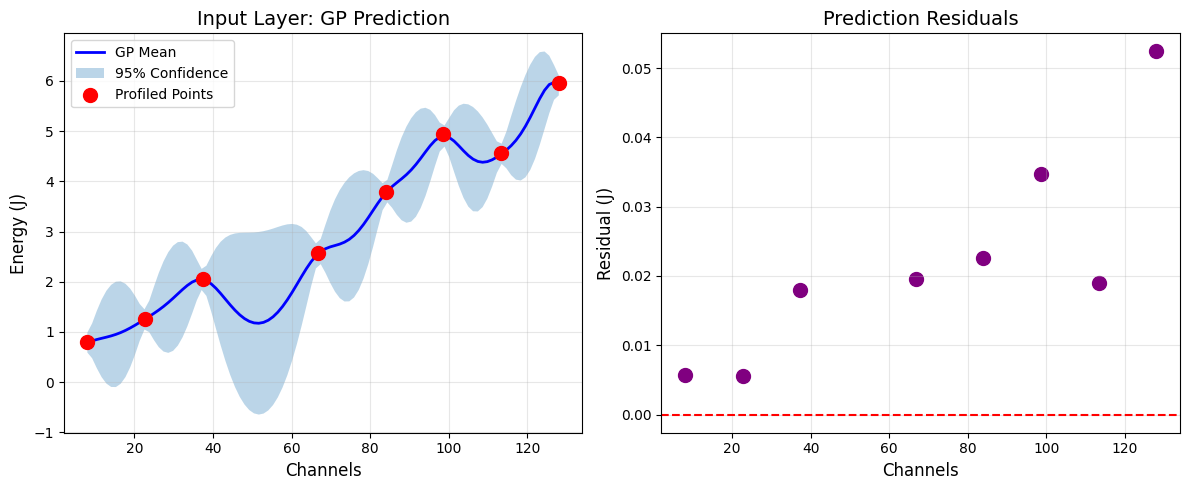

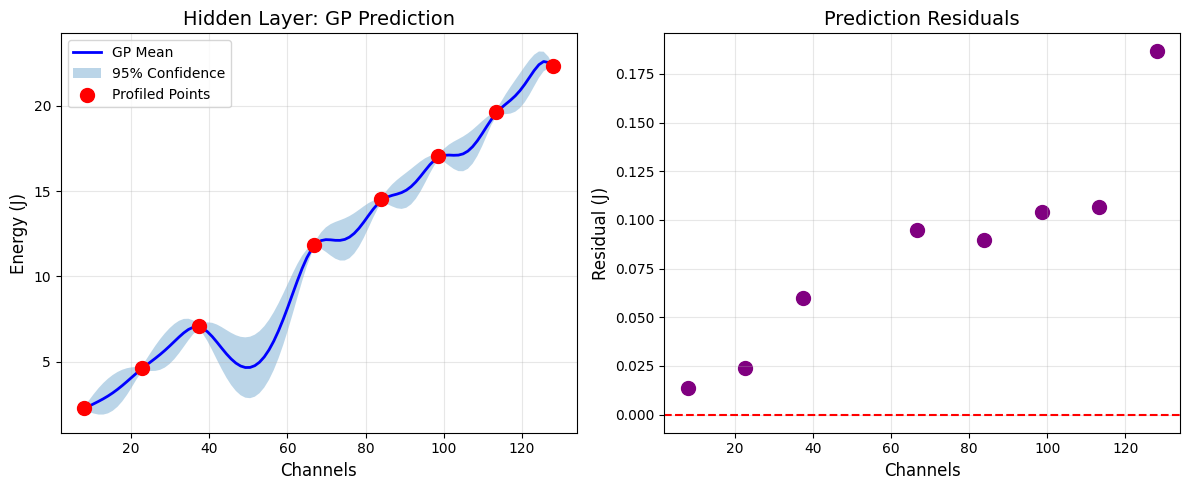



Phase 3: Energy Estimation for Different Models

Small CNN:
  Input: 32 channels
  Hidden: 2 layers
  Total Energy: 30.18 J
  Breakdown:
    Input Layer: 1.83 J
    Hidden Layer 1: 7.95 J
    Hidden Layer 2: 10.60 J
    Output Layer: 9.80 J

Medium CNN:
  Input: 64 channels
  Hidden: 3 layers
  Total Energy: 65.10 J
  Breakdown:
    Input Layer: 2.29 J
    Hidden Layer 1: 15.90 J
    Hidden Layer 2: 21.20 J
    Hidden Layer 3: 15.90 J
    Output Layer: 9.80 J

Large CNN:
  Input: 128 channels
  Hidden: 4 layers
  Total Energy: 137.62 J
  Breakdown:
    Input Layer: 5.91 J
    Hidden Layer 1: 31.80 J
    Hidden Layer 2: 42.40 J
    Hidden Layer 3: 31.80 J
    Hidden Layer 4: 15.90 J
    Output Layer: 9.80 J


Phase 4: Energy Comparison Across Models


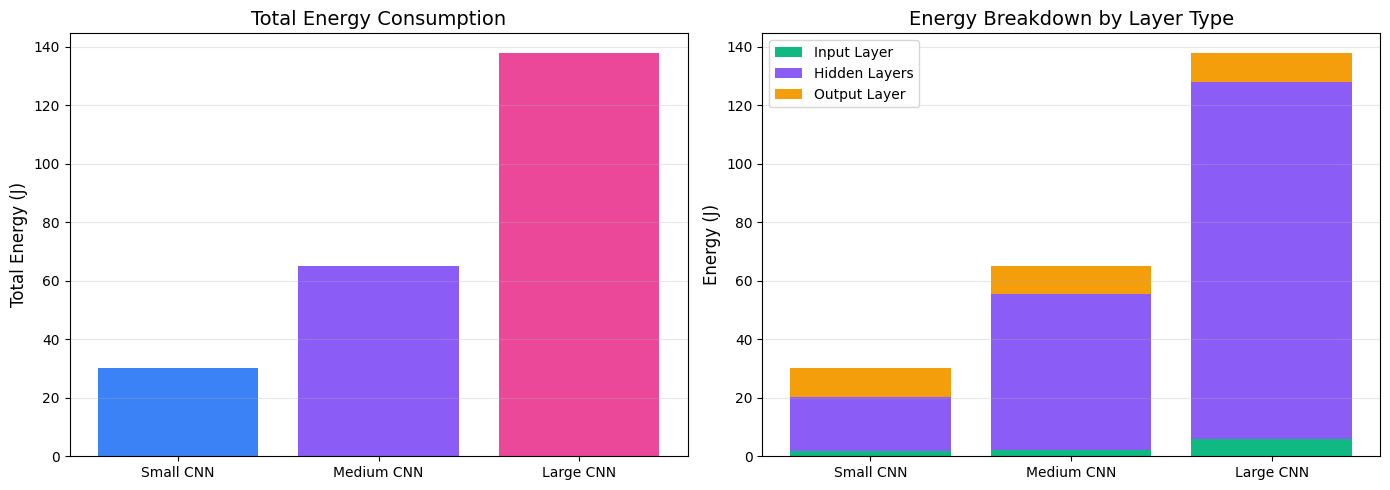

completed!


In [ ]:

if __name__ == "__main__":
    np.random.seed(42)
    main()